In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

import pandas as pd

import sys
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical


In [28]:
data = pd.read_csv('../../../../data/titanic_train.csv', index_col='PassengerId').drop(['Ticket', 'Cabin', 'Name'], axis='columns')
print(f'Всего данных: {data.shape[0]}')
data.head(11)

Всего данных: 891


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
6,0,3,male,NaN,0,0,8.4583,Q
7,0,1,male,54.0,0,0,51.8625,S
8,0,3,male,2.0,3,1,21.0750,S
9,1,3,female,27.0,0,2,11.1333,S


In [29]:
# Пишем наши собственные препроцессоры
class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.fillna(method='pad')

class DropOutlet(TransformerMixin, BaseEstimator): 
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[(X_cols - X_cols.mean()).abs() <= 3*self.std].dropna()
    
class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values

class GetArray(BaseEstimator):
    def fit(self, X : pd.DataFrame = None, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)

class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """

    def __init__(self, axis):
        self.axis = axis

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

In [30]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
# выбираем данные для обучающей выборки (то что будет подано на вход алгоритмам машинного обучения)

# Кодируем все классы в виде единичных векторов
data_Y = data['Pclass']
data_X = pd.get_dummies(data.drop('Pclass', axis=1), columns=['Sex', 'Embarked'])
# X is number data now
print(data_X.columns)

# Убираем вылеты из данных
fill_pl = pipeline.Pipeline([
    ('na', FillNa()),
])

outlet_pl = pipeline.Pipeline([
    ('fill', fill_pl),
    ('drop outlet', DropOutlet()),
])

data_X = outlet_pl.fit_transform(data_X)
data_Y = data_Y[fill_pl.fit_transform(data_Y).index.isin(data_X.index)]

# Нормализуем данные X
normX_pl = pipeline.Pipeline([
    ('array', GetArray()),
    ('mormalize', preprocessing.MinMaxScaler())
])
# Нормализуем данные Y
normY_pl = pipeline.Pipeline([
    ('array', GetArray()),
    ('encode labels', ModifyLabelEncoder()),
    ('add dim', ExpandDims(axis=1)),
    ('one hot or dummy', preprocessing.OneHotEncoder(sparse=False))
])

data_X = normX_pl.fit_transform(data_X)
data_Y = normY_pl.fit_transform(data_Y)


Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [34]:
data_X[:6], data_Y[:10]

(array([[0.        , 0.30575234, 0.33333333, 0.        , 0.04397492,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.53244545, 0.33333333, 0.        , 0.4323693 ,
         1.        , 0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.36242562, 0.        , 0.        , 0.04806914,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [1.        , 0.48994049, 0.33333333, 0.        , 0.32207838,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.48994049, 0.        , 0.        , 0.04882733,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.75913857, 0.        , 0.        , 0.31457232,
         0.        , 1.        , 0.        , 0.        , 1.        ]]),
 array([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0

In [41]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import callbacks
from keras.models import load_mode
import re

model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=data_X.shape[1]))
model.add(Dense(data_y.shape[1], activation=activations.softmax))
model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])

In [42]:
model.fit(data_X, data_Y, verbose=2, epochs=100, batch_size=3)
#print(model.evaluate(data_X, data_y))


Epoch 1/100
 - 0s - loss: 1.0652 - categorical_accuracy: 0.4768
Epoch 2/100
 - 0s - loss: 0.9944 - categorical_accuracy: 0.5046
Epoch 3/100
 - 0s - loss: 0.9512 - categorical_accuracy: 0.5471
Epoch 4/100
 - 0s - loss: 0.8900 - categorical_accuracy: 0.6202
Epoch 5/100
 - 0s - loss: 0.8296 - categorical_accuracy: 0.6560
Epoch 6/100
 - 0s - loss: 0.7807 - categorical_accuracy: 0.7039
Epoch 7/100
 - 0s - loss: 0.7431 - categorical_accuracy: 0.7105
Epoch 8/100
 - 0s - loss: 0.7128 - categorical_accuracy: 0.7291
Epoch 9/100
 - 0s - loss: 0.6874 - categorical_accuracy: 0.7424
Epoch 10/100
 - 0s - loss: 0.6672 - categorical_accuracy: 0.7530
Epoch 11/100
 - 0s - loss: 0.6493 - categorical_accuracy: 0.7477
Epoch 12/100
 - 0s - loss: 0.6361 - categorical_accuracy: 0.7716
Epoch 13/100
 - 0s - loss: 0.6241 - categorical_accuracy: 0.7649
Epoch 14/100
 - 0s - loss: 0.6117 - categorical_accuracy: 0.7756
Epoch 15/100
 - 0s - loss: 0.6037 - categorical_accuracy: 0.7716
Epoch 16/100
 - 0s - loss: 0.5935 

In [43]:
### перемешаем и получим тестовую выборку

data_Xy = np.hstack((data_X, data_y))
np.random.shuffle(data_Xy)

point_split = round(data_Xy.shape[0] * 0.8)
train_data = data_Xy[:point_split]
test_data = data_Xy[point_split:]

print(f'Всего данных: {data_Xy.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')

Всего данных: 753
Тренировочных данных: 602
Тестовых данных: 151


In [44]:
# Тренировочные
X_train = train_data[:, :data_X.shape[1]]
Y_train = train_data[:, data_X.shape[1]:]
print(f'Размер данных для тренировки (входных): {X_train.shape}')
print(f'Размер данных для тренировки (выходных): {Y_train.shape}')
print(X_train)
print(Y_train)


Размер данных для тренировки (входных): (602, 10)
Размер данных для тренировки (выходных): (602, 3)
[[1.         0.41909889 0.         ... 1.         0.         0.        ]
 [1.         0.03655426 0.33333333 ... 0.         0.         1.        ]
 [1.         0.30575234 0.         ... 0.         0.         1.        ]
 ...
 [1.         0.33408898 0.33333333 ... 0.         0.         1.        ]
 [0.         0.63162369 0.         ... 1.         0.         0.        ]
 [1.         0.41909889 0.         ... 0.         0.         1.        ]]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [45]:
# Тестовые
X_test = test_data[:, :data_X.shape[1]]
Y_test = test_data[:, data_X.shape[1]:]
print(f'Размер данных для теста (входных): {X_test.shape}')
print(f'Размер данных для теста (выходных): {Y_test.shape}')


Размер данных для теста (входных): (151, 10)
Размер данных для теста (выходных): (151, 3)


In [46]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

model = make_nn(X_train.shape[1], Y_train.shape[1])



In [13]:
from pathlib import Path
from os import remove

file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('./').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))


print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
#     Так как у нас теперь есть рання остановка мы можем увеличеть количество эпох (было 100 стало 300)
    epochs=300,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
#             На основе какого значения будет приниматься решеня об остановке
            monitor='val_categorical_accuracy',
#             Указываем направления лучшего значения (min, max, auto) лучшим является если тестовая точноть будет максимальной
            mode='max',
#             Количество эпок в резельтате которых если значение не изменилось, то произвести остановку
            patience=50,
#             "Чуствительность" метода - изменения ниже данного значения дубут считатья 0 (изменения в отслеживаемом значении нету)
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)


Начинаем обучение сети
Текущий каталог с контрольными точками C:\Users\Vazi\Documents\GitHub\AI_1\лабы_решения\1562_2\Савельев Д.В\Lab5\save_points
Train on 481 samples, validate on 121 samples
Epoch 1/300
481/481 [==============================] - 0s 433us/step - loss: 1.1591 - categorical_accuracy: 0.3971 - val_loss: 1.0051 - val_categorical_accuracy: 0.6033
Epoch 2/300
481/481 [==============================] - 0s 172us/step - loss: 1.0830 - categorical_accuracy: 0.4657 - val_loss: 0.9770 - val_categorical_accuracy: 0.6033
Epoch 3/300
481/481 [==============================] - 0s 158us/step - loss: 1.0474 - categorical_accuracy: 0.4657 - val_loss: 0.9514 - val_categorical_accuracy: 0.6116
Epoch 4/300
481/481 [==============================] - 0s 164us/step - loss: 1.0152 - categorical_accuracy: 0.4761 - val_loss: 0.9325 - val_categorical_accuracy: 0.6529
Epoch 5/300
481/481 [==============================] - 0s 156us/step - loss: 0.9828 - categorical_accuracy: 0.5551 - val_loss: 0.9

481/481 [==============================] - 0s 167us/step - loss: 0.5242 - categorical_accuracy: 0.8004 - val_loss: 0.7101 - val_categorical_accuracy: 0.7521
Epoch 49/300
481/481 [==============================] - 0s 156us/step - loss: 0.5236 - categorical_accuracy: 0.8046 - val_loss: 0.7203 - val_categorical_accuracy: 0.7438
Epoch 50/300
481/481 [==============================] - 0s 156us/step - loss: 0.5215 - categorical_accuracy: 0.8025 - val_loss: 0.7163 - val_categorical_accuracy: 0.7521
Epoch 51/300
481/481 [==============================] - 0s 156us/step - loss: 0.5190 - categorical_accuracy: 0.7983 - val_loss: 0.7164 - val_categorical_accuracy: 0.7521
Epoch 52/300
481/481 [==============================] - 0s 158us/step - loss: 0.5203 - categorical_accuracy: 0.7942 - val_loss: 0.7126 - val_categorical_accuracy: 0.7603
Epoch 53/300
481/481 [==============================] - 0s 156us/step - loss: 0.5158 - categorical_accuracy: 0.8087 - val_loss: 0.7187 - val_categorical_accuracy: 

481/481 [==============================] - 0s 158us/step - loss: 0.4719 - categorical_accuracy: 0.8274 - val_loss: 0.7782 - val_categorical_accuracy: 0.7769
Epoch 97/300
481/481 [==============================] - 0s 156us/step - loss: 0.4736 - categorical_accuracy: 0.8358 - val_loss: 0.7610 - val_categorical_accuracy: 0.7686
Epoch 98/300
481/481 [==============================] - 0s 164us/step - loss: 0.4729 - categorical_accuracy: 0.8358 - val_loss: 0.7794 - val_categorical_accuracy: 0.7769
Epoch 99/300
481/481 [==============================] - 0s 151us/step - loss: 0.4715 - categorical_accuracy: 0.8316 - val_loss: 0.7690 - val_categorical_accuracy: 0.7686
Epoch 100/300
481/481 [==============================] - 0s 153us/step - loss: 0.4713 - categorical_accuracy: 0.8337 - val_loss: 0.7677 - val_categorical_accuracy: 0.7686
Epoch 101/300
481/481 [==============================] - 0s 151us/step - loss: 0.4725 - categorical_accuracy: 0.8358 - val_loss: 0.7704 - val_categorical_accuracy

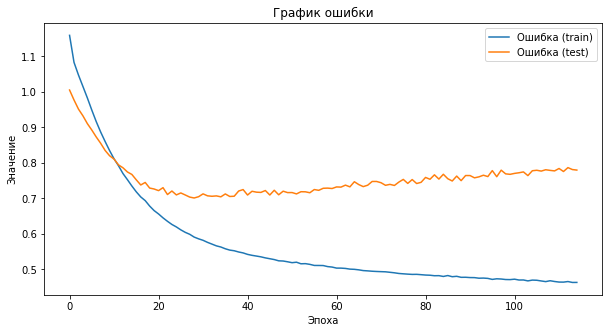

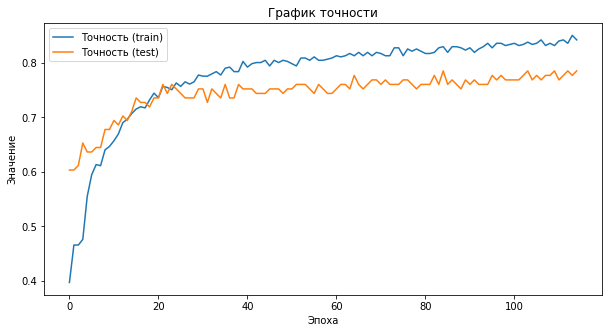

In [14]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);



# Загружаем контрольную точку (модель)
mx_acc = 0.00;
checkpoints_dir = Path('./').joinpath('save_points')
for item in checkpoints_dir.iterdir():
    if item.is_file():
        res = re.search(r'val_acc-(\d\.\d)', str(item))
        if res is not None:
            cur_acc = float(res.group(1))
            if cur_acc > mx_acc:
                mx_acc = cur_acc
                fname = str(item)

loaded_model = load_model(fname)

In [15]:
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
print(predict)

602/602 [==============================] - 0s 46us/step
Точность предсказания на тренировочных данных 0.8272425241248552
151/151 [==============================] - 0s 13us/step
Точность предсказания на тестовых данных 0.8410596030437394
[2 1 2 0 1 2 2 0 0 1 2 2 2 0 2 2 2 2 2 2 1 0 2 0 2 2 2 2 0 2 2 2 2 0 1 1 0
 0 2 0 2 2 1 0 2 2 0 2 2 1 2 0 2 2 2 2 1 2 2 2 1 2 1 1 2 2 1 0 2 0 2 2 2 2
 1 2 2 0 0 0 0 2 2 2 1 2 2 0 2 2 2 2 2 0 2 1 2 1 2 2 2 0 0 2 2 1 2 0 2 1 2
 0 1 0 2 1 0 2 2 2 1 2 2 1 2 0 0 0 2 0 1 2 2 1 0 2 2 2 2 0 2 2 0 2 2 2 1 2
 2 2 2]


In [16]:
# Преобразуем классы в виде числа в их оригеналы
print(normy_pl.named_steps['encode labels'].inverse_transform(predict))

# Прдсказываем вероятности для классов
print(loaded_model.predict(X_train))

[3 2 3 1 2 3 3 1 1 2 3 3 3 1 3 3 3 3 3 3 2 1 3 1 3 3 3 3 1 3 3 3 3 1 2 2 1
 1 3 1 3 3 2 1 3 3 1 3 3 2 3 1 3 3 3 3 2 3 3 3 2 3 2 2 3 3 2 1 3 1 3 3 3 3
 2 3 3 1 1 1 1 3 3 3 2 3 3 1 3 3 3 3 3 1 3 2 3 2 3 3 3 1 1 3 3 2 3 1 3 2 3
 1 2 1 3 2 1 3 3 3 2 3 3 2 3 1 1 1 3 1 2 3 3 2 1 3 3 3 3 1 3 3 1 3 3 3 2 3
 3 3 3]
[[1.7890885e-02 2.0132700e-01 7.8078216e-01]
 [1.1332714e-01 7.2602952e-01 1.6064331e-01]
 [3.0336868e-02 2.3511747e-01 7.3454571e-01]
 ...
 [1.0246078e-01 1.3350300e-01 7.6403630e-01]
 [7.3863548e-01 2.1736901e-01 4.3995492e-02]
 [9.9361414e-01 6.3528745e-03 3.3096989e-05]]


C:\Users\Vazi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(753, 2)


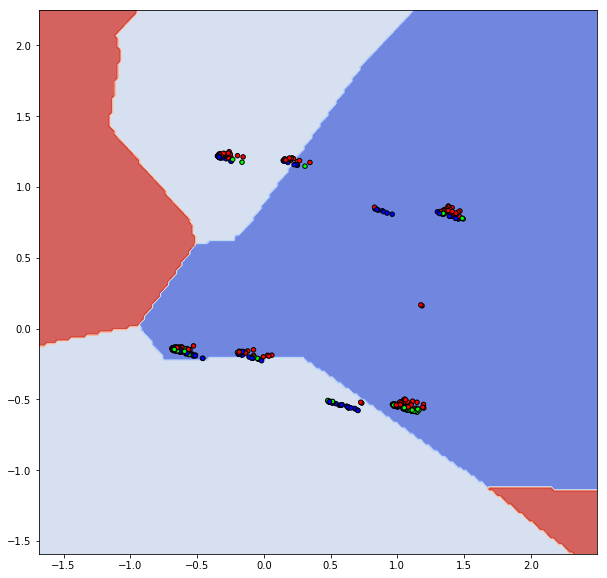

In [48]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional
    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', GetArray()),
    ('label_encoder', ModifyLabelEncoder()),
])

#Y = pipe_y_mini.fit_transform(data_y)
Y = data_y
X = data_X

pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

plt.show()